# Infection Transcriptome - Data Analysis

Now that we have normalized data for each of the read counts, we can now begin to visualize the differentiation in the counts. We will use Principal Component Analysis (PCA) and create a heatmap for data visualiztaion. However, as we are dealing with an abundance of genes (at least four is what matters), we must reduce the variations across genes into two axes. This is the first goal: to reduce dimensionality of variation to clearly identify differences.

## Principal Component Analysis

Principal Component Analysis (PCA) focuses on reducing the dimensionality of multiple measurements, in this case the TPM of genes, to delinate variations between data sets. The basis is to create a best-fit line, called PC1, of the plotted points due to measures of gene counts. The data is then shifted with the best-fit line so that the best-fit line hits the origin. A second best-fit line is then plotted, PC2, long it be perpendicular to PC1 and is the best-fit in the limited dimension. The x/y plot can be created with PC1 treated as the x-axis and PC2 as the y-axis.

Too long, didn't read; PCA is simply a tool that allows us to visualize the differentiation of the transcriptomes. Here's how to do it:

### Setup

Make sure to setup your working directory.

In [1]:
import os

os.environ['WORKDIR'] = './data'

### Dependencies

You will need the following libaries, which can be imported using the pip command on your terminal.

In [2]:
import pandas as pd # "Panel data" package allows easy manipulation of data
import numpy as np # Allows us to do important math
from sklearn.decomposition import PCA # Importing PCA function from sklearn
from sklearn import preprocessing # Package to scale data
import matplotlib.pyplot as plt # Allows you to draw graphs

### Loading Data

We must now load the data of all the tpm counts for each sample. However, according to the study, we must filter out transcripts that are lowly expressed in all samples, with a total count filter cutoff of five. Therefore, we must load both the estimated counts and transcripts per million data for the filtering and the charting, respectively.

In [3]:
# Import data
# Access est_counts for filtering and scaling
vit1 = pd.read_table(os.environ['WORKDIR'] + '/kallisto/in_vitro_1/abundance.tsv', usecols=['target_id', 'est_counts'])
vit2 = pd.read_table(os.environ['WORKDIR'] + '/kallisto/in_vitro_2/abundance.tsv', usecols=['target_id', 'est_counts'])
vit3 = pd.read_table(os.environ['WORKDIR'] + '/kallisto/in_vitro_3/abundance.tsv', usecols=['target_id', 'est_counts'])
viv1 = pd.read_table(os.environ['WORKDIR'] + '/kallisto/in_vivo_1/abundance.tsv', usecols=['target_id', 'est_counts'])
viv2 = pd.read_table(os.environ['WORKDIR'] + '/kallisto/in_vivo_2/abundance.tsv', usecols=['target_id', 'est_counts'])
viv3 = pd.read_table(os.environ['WORKDIR'] + '/kallisto/in_vivo_3/abundance.tsv', usecols=['target_id', 'est_counts'])

# Merge samples into one table, where the row represents transcripts and columns for each sample
data = pd.DataFrame(columns=['vit1','vit2','vit3','viv1','viv2','viv3'], index=list(map(lambda pair:pair[0], vit1.values)))

# Collect rows where total counts are less than five to filter later
cutoff = 5
lows = []
for i in range(len(data.index)):
    gene = data.index[i]
    counts = sum([vit1.iloc[i][1], vit2.iloc[i][1], vit3.iloc[i][1], viv1.iloc[i][1], viv2.iloc[i][1], viv3.iloc[i][1]])
    if counts < cutoff:
        lows.append(gene)
    data.loc[gene, 'vit1'] = vit1.iloc[i][1]
    data.loc[gene, 'vit2'] = vit2.iloc[i][1]
    data.loc[gene, 'vit3'] = vit3.iloc[i][1]
    data.loc[gene, 'viv1'] = viv1.iloc[i][1]
    data.loc[gene, 'viv2'] = viv2.iloc[i][1]
    data.loc[gene, 'viv3'] = viv3.iloc[i][1]

# Filter collected rows - doing it in loop messes things up!
data.drop(index=lows, inplace=True)

# Clear memory, samples no longer needed
del vit1,vit2,vit3,viv1,viv2,viv3

# Display data counts and dimensions
print(data.head())
print(data.shape)

            vit1 vit2 vit3 viv1 viv2 viv3
VIMSS511295   13    5   16   18   48   43
VIMSS511296    7    6    1    1   10    5
VIMSS511297    8    4    3    9    9   12
VIMSS511298    8    4    4    1    6    5
VIMSS511299   12   11   10    4    9   13
(2978, 6)


### Scaling and Centering

We will center and scale the data. After centering, the average value of each gene will be scaled to zero (i.e. transcripts that have a lower expression of that gene will have a negative gene measure). After scaling, the standard deviation of the values of the genes will be one. Citation: I must give complete credit at this point to this [StatQuest](https://www.youtube.com/watch?v=Lsue2gEM9D0&list=PLblh5JKOoLUJo2Q6xK4tZElbIvAACEykp&index=5) video to explain how to do Python PCA for RNA-seq. Really appreciate the video.

In [4]:
# Transpose (data.T) because scale function expects samples as rows
scaled_data = preprocessing.StandardScaler().fit_transform(data.T)

### Sklearn

The next few steps may seem like a breeze, but it is important to understand the process of creating a PCA graph.
- Create as many best-fit lines the number of genes; this is the number of dimensions of measurements. Check out this video from [StatQuest](https://www.youtube.com/watch?v=FgakZw6K1QQ&list=PLblh5JKOoLUJo2Q6xK4tZElbIvAACEykp&index=3) to learn more.
- There is a new x/y plot of PC1/PC2, the "loading scores", or proportion of each genes due to the best fit line, that create the greatest variation, and the original points of gene expressions are projected based on original projections to the lines.

In [5]:
# Create PCA object
pca = PCA()

# # Fit the scaled data
pca.fit(scaled_data)

# # Generate coordinates for PCA graph by loading scores and scaled data
pca_data = pca.transform(scaled_data)

## Scree Plot

Scree plots are useful for presenting the variation of gene expression between samples due to loading scores, the combinations of genes that make up a unit vector on the PCA line. This will tell us which combinations account for the greatest variation, allowing the best representation of differential expression.

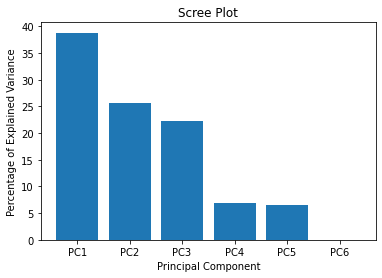

In [6]:
# Calculate percentage of variation of each principal component (loading score)
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)

# Create labels for scree plot - one per principal component
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

# Matplotlib to create bar chart
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

### PCA Plot (finally)

It seems that there are three principal components with a significant explained variance, so we will create three graphs to chart each relationship.

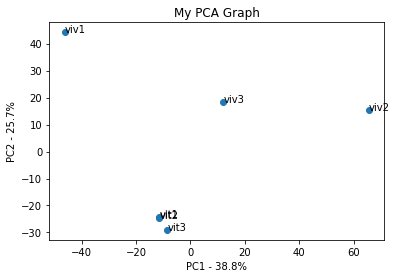

In [7]:
# Create PCA plot in matrix where rows are sample labels and columns are PC labels
pca_df = pd.DataFrame(pca_data, index=data.columns, columns=labels)

# Draw scatter plot with title and axis labels
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

# Add sample names to graph
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

# Display graph
plt.show()

The *in vivo* samples seem to be quite differentially expressed in terms of PC1. On the other hand, the PC2 seems to do a better job of charting the differences between the transcripts. There is certainly uncertainty in the experiment, but differentiation exists between the two groups.

My hypothesis would be that the *in vivo* transcripts are more differentiated from each other than *in vitro* transcripts because of differences in environment. The lab environments *in vitro* are more the less the same when testing the same species. In the study, however, it was noted that the *in vivo* gene expression profile did not precisely match the virulence gene expression and additional factors independent from the gene system are involved in the pathogenesis and survival of *B. pertussis* during infection. In fact, there seemed to be no correlation between virulence activated genes *in vivo* and *in vitro*. The counterintuitive results suggests that perhaps the bacteria were in difference virulent phases depending on the factors such as nutrient availability and growth conditions within the murine lung environment, which would lead to different expression of transcripts.

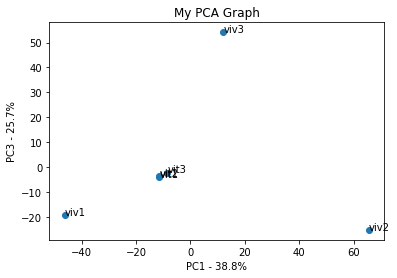

In [8]:
# Create PCA plot in matrix where rows are sample labels and columns are PC labels
pca_df = pd.DataFrame(pca_data, index=data.columns, columns=labels)

# Draw scatter plot with title and axis labels
plt.scatter(pca_df.PC1, pca_df.PC3)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC3 - {0}%'.format(per_var[1]))

# Add sample names to graph
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC3.loc[sample]))

# Display graph
plt.show()

It seems that PC3 does not seem to project the differences between the sample groups definitively, also possibly due to variation in the environment.

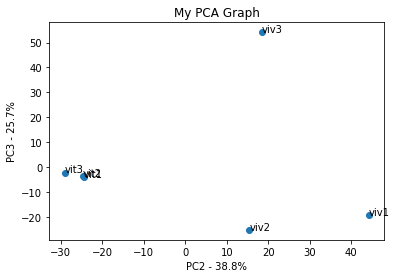

In [9]:
# Create PCA plot in matrix where rows are sample labels and columns are PC labels
pca_df = pd.DataFrame(pca_data, index=data.columns, columns=labels)

# Draw scatter plot with title and axis labels
plt.scatter(pca_df.PC2, pca_df.PC3)
plt.title('My PCA Graph')
plt.xlabel('PC2 - {0}%'.format(per_var[0]))
plt.ylabel('PC3 - {0}%'.format(per_var[1]))

# Add sample names to graph
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC2.loc[sample], pca_df.PC3.loc[sample]))

# Display graph
plt.show()

It seems that PC2 best demonstrates the differential expression between the two groups of samples. Accordingly, there were four groups of virulent genes that were consistently activiated when infecting the murine host: iron acquisition, type III secretion system, pertussis toxin (PT), and secretion. When we do our loading scores analysis, perhaps we can expect to see high loading scores for those genes for PC2.

### Loading Scores

Perhaps this will allow us to explain the relatively disappointing results of our PCA graph. We want to determine which genes had the largest influence on separating the two clusters for each graph, so maybe there will be insights. We will do the loading scores for the three principal components below.

In [10]:
# Create pandas "Series" with loading scores
loading_scores = pd.Series(pca.components_[0], index=data.index)

# Sort loading scores based on magnitude
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

# Get names of top 10 gene names
top_10_genes = sorted_loading_scores[0:10].index.values

# Print out top ten gene names and loading scores
print(loading_scores[top_10_genes])

VIMSS514526    0.029356
VIMSS513974    0.029324
VIMSS515063    0.029286
VIMSS514456    0.029273
VIMSS512264    0.029209
VIMSS514361    0.029162
VIMSS513728    0.029093
VIMSS513729    0.029091
VIMSS513819    0.029066
VIMSS513777    0.029059
dtype: float64


In [11]:
# Create pandas "Series" with loading scores
loading_scores = pd.Series(pca.components_[1], index=data.index)

# Sort loading scores based on magnitude
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

# Get names of top 10 gene names
top_10_genes = sorted_loading_scores[0:10].index.values

# Print out top ten gene names and loading scores
print(loading_scores[top_10_genes])

VIMSS512701   -0.036064
VIMSS513077   -0.036057
VIMSS514844   -0.036047
VIMSS511715   -0.036047
VIMSS514141   -0.035986
VIMSS511548   -0.035974
VIMSS513057   -0.035936
VIMSS514241   -0.035888
VIMSS515115   -0.035869
VIMSS512132   -0.035855
dtype: float64


In [12]:
# Create pandas "Series" with loading scores
loading_scores = pd.Series(pca.components_[2], index=data.index)

# Sort loading scores based on magnitude
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

# Get names of top 10 gene names
top_10_genes = sorted_loading_scores[0:10].index.values

# Print out top ten gene names and loading scores
print(loading_scores[top_10_genes])

VIMSS512081    0.038777
VIMSS513980    0.038688
VIMSS512518    0.038688
VIMSS514756    0.038593
VIMSS512735    0.038486
VIMSS513858    0.038404
VIMSS514897    0.038403
VIMSS513100    0.038384
VIMSS514891    0.038366
VIMSS512034    0.038269
dtype: float64


These tell us the genes that cause the greatest differentiation in expression between the samples. Perhaps the best set of transcripts to determine differential expression between the two groups of samples would be PC2; however, it is important to consider all sets to avoid confirmation bias. Furthermore, there is a relative cluster in PC1 for the *in vivo* transcripts, with the exception of an outlier.

Two takeaways: first that at least we can see that the *in vivo* transcripts and *in vitro* transcripts are differentially expressed and second, the *in vitro* transcripts are more or less similarly expressed, while *in vivo* transcripts forming a less definitve, if at all, cluster.

## Heatmap

My ultimate goal of this project was to try to create a heatmap to represent the expression of genes in each sample. This is what we attempt to do today. No section-by-section analysis, simply code to run the heatmap, as it is quite simple to code.

Of course, this will not be any ordinary heatmap. We will rely on hierarchical clustering to group the genes according to similar expression. Technically the first step is to scale the data, but it is already scaled for us by using TPM.

In [13]:
# Import seaborn to use clustermap
import seaborn as sns

In [14]:
# Do color coding
sns.set(color_codes=True)

We will focus on the top ten genes for PC2 to get the greatest differentiation between the two sample groups.

In [15]:
# Create pandas "Series" with loading scores
loading_scores = pd.Series(pca.components_[1], index=data.index)

# Sort loading scores based on magnitude
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

# Get names of top 10 gene names
top_10_genes = sorted_loading_scores[0:10].index.values

# Print out top ten gene names and loading scores
print(loading_scores[top_10_genes])

VIMSS512701   -0.036064
VIMSS513077   -0.036057
VIMSS514844   -0.036047
VIMSS511715   -0.036047
VIMSS514141   -0.035986
VIMSS511548   -0.035974
VIMSS513057   -0.035936
VIMSS514241   -0.035888
VIMSS515115   -0.035869
VIMSS512132   -0.035855
dtype: float64


In [16]:
# Import data
# Access est_counts for filtering and scaling
# However, now using tpm for scaled data
vit1 = pd.read_table(os.environ['WORKDIR'] + '/kallisto/in_vitro_1/abundance.tsv', usecols=['target_id', 'est_counts', 'tpm'])
vit2 = pd.read_table(os.environ['WORKDIR'] + '/kallisto/in_vitro_2/abundance.tsv', usecols=['target_id', 'est_counts', 'tpm'])
vit3 = pd.read_table(os.environ['WORKDIR'] + '/kallisto/in_vitro_3/abundance.tsv', usecols=['target_id', 'est_counts', 'tpm'])
viv1 = pd.read_table(os.environ['WORKDIR'] + '/kallisto/in_vivo_1/abundance.tsv', usecols=['target_id', 'est_counts', 'tpm'])
viv2 = pd.read_table(os.environ['WORKDIR'] + '/kallisto/in_vivo_2/abundance.tsv', usecols=['target_id', 'est_counts', 'tpm'])
viv3 = pd.read_table(os.environ['WORKDIR'] + '/kallisto/in_vivo_3/abundance.tsv', usecols=['target_id', 'est_counts', 'tpm'])

# Merge samples into one table, where the row represents transcripts and columns for each sample
data = pd.DataFrame(columns=['vit1','vit2','vit3','viv1','viv2','viv3'], index=list(map(lambda pair:pair[0], vit1.values)))

# Collect rows where total counts are less than five to filter later
cutoff = 5
lows = []
for i in range(len(data.index)):
    gene = data.index[i]
    counts = sum([vit1.iloc[i][1], vit2.iloc[i][1], vit3.iloc[i][1], viv1.iloc[i][1], viv2.iloc[i][1], viv3.iloc[i][1]])
    if counts < cutoff or gene not in top_10_genes:
        lows.append(gene)
    data.loc[gene, 'vit1'] = vit1.iloc[i][2]
    data.loc[gene, 'vit2'] = vit2.iloc[i][2]
    data.loc[gene, 'vit3'] = vit3.iloc[i][2]
    data.loc[gene, 'viv1'] = viv1.iloc[i][2]
    data.loc[gene, 'viv2'] = viv2.iloc[i][2]
    data.loc[gene, 'viv3'] = viv3.iloc[i][2]

# Filter collected rows - doing it in loop messes things up!
data.drop(index=lows, inplace=True)

# Clear memory, samples no longer needed
del vit1,vit2,vit3,viv1,viv2,viv3

# Display data counts and dimensions
print(data.head())
print(data.shape)

                vit1     vit2     vit3     viv1     viv2     viv3
VIMSS511548      431  374.922  394.694  138.196   138.82  195.392
VIMSS511715  9.54521  8.53339  8.35354        0  2.08367  2.99121
VIMSS512132   193.02  151.535  164.241  15.3449  44.3485  58.8144
VIMSS512701   177.13  154.383  155.276  79.7134  68.6389  98.3579
VIMSS513057  376.761  320.989  323.126  126.187  122.358  191.197
(10, 6)


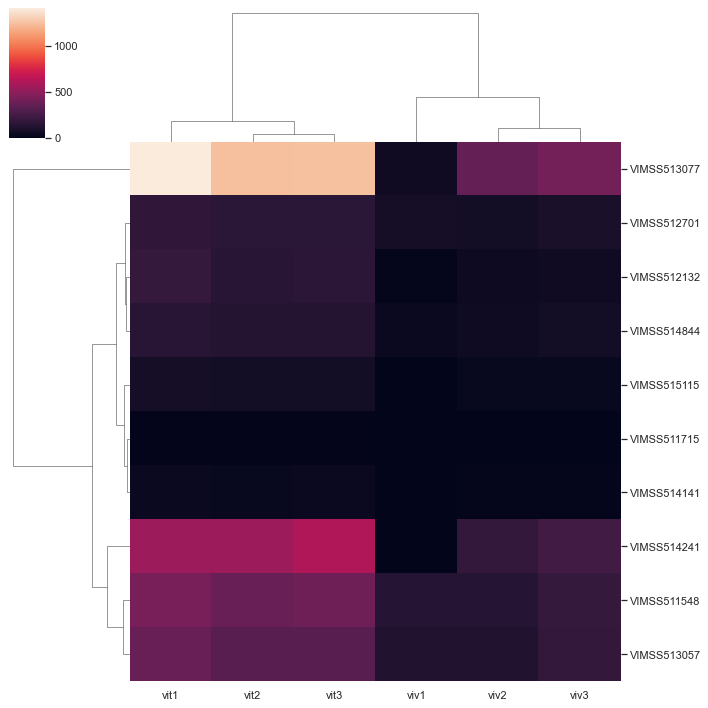

In [17]:
# Create clustermap after converting values to float
data = data[data.columns].astype(float)
sns.clustermap(data)

Here the evidence of differential expression is evident between the two groups of samples. We can see that the *in vitro* samples have very similar transcriptome expressions, and can generally be distinguished from the *in vivo* samples. This is one of the benefits of creating a heatmap: visualizing the differences through color as it pops out to the human eye.

## Conclusion

Overall, while this is simply the beginning of data analysis for RNA-seq, it is a start. While we did not get the clear, distinctive differential clustering of the *in vivo* and *in vitro* samples of *B. pertussis* as we had expected, we were still able to see clear differentiation in expression. This was the ultimate goal of this project: to visualize differential expression using a dataset, and thus we were successful.

Perhaps in terms of scientific study, the most important takeaway is the loading scores. Looking at what genes created the greatest variation for the principal component best differentiating the two sample groups will determine differential expression for the infection transcriptome. It is possible that the other two principal components were due to experimental uncertainty, however, and should not be ignored. Rather, those loading scores should be analyzed to understand potential improvements to both the experiment and analysis. Neither are perfect; very likely it would be my analysis more off the mark.

This was an excellenet learning experience. At least we know how to create these data visualization techniques, and that will always be important in modeling. In terms of systems thinking, here are a few takeaways:
- Influence of multiple genes and transcripts in differential expression
- The variation of the transcripts of *in vivo* samples, suggesting the influence of external factors
- Correlation between expression of genes, such as the activation of one gene prompting the activation/reduction in another

That is a wrap for the tutorial. Please let me know if you have any concerns in the issues page on the Github, and I would be happy to reach out.